In [205]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3


%matplotlib notebook
from sklearn.preprocessing import Imputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import chi2_contingency
from sklearn import preprocessing

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import AdaBoostClassifier

E:\installed anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [142]:
from scipy.stats import zscore
import os
from sqlite3 import sqlite_version

# IMPORTING DATA

In [210]:
os.chdir('C:\\Users\\user\\Downloads')

In [211]:
db = 'kinara_assessment_20181008.db'

In [212]:
conn = sqlite3.connect('kinara_assessment_20181008.db')


In [213]:
loan_info = pd.read_sql_query("select * from loan_information",con=conn,index_col=None,parse_dates=['screening_date'])

In [214]:
enteprise_info = pd.read_sql_query("select * from enteprise_information",con=conn,index_col=None)

In [215]:
scores_info = pd.read_sql_query("select * from scores_information",con=conn,index_col=None)

In [216]:
disbursements_info = pd.read_sql_query("select * from disbursements_information",con=conn,index_col=None, 
                                      parse_dates = ['transaction_Date'])

In [217]:
rd = pd.merge(loan_info, scores_info.drop_duplicates(subset = ['loan_id']), how='outer',
                     left_on=['loan_id'],right_on= ['loan_id'])

In [218]:
rd2 = pd.merge(rd, enteprise_info.drop_duplicates(subset = ['enterprise_id']), how='outer',
                     left_on=['enterprise_id'],right_on= ['enterprise_id'])

In [219]:
p2 = pd.merge(rd2, disbursements_info.drop_duplicates(subset = ['account_number']), how='outer',
                     left_on=['account_number'],right_on= ['account_number'])

In [220]:
len(p2)

2662

In [221]:
p2.head()

,loan_id,account_number,customer_id,enterprise_id,screening_date,product_code,hub_id,ManagAgeui_APP,BusinFormalityOfTheBusinessui,ManagCBscoreui_APP,business_type,business_activity,business_sector,net_disbursement_magnitude,transaction_Date
0,5692,TLMFS0000055,17850,6278,2017-03-07,TLMFS,46,32,Cash & Non Banked,0,Manufacturing,Job Work,Auto Components,345909.0,2017-02-28
1,6190,TLWCU0001219,17857,6280,2017-03-07,TLWCU,32,35,Cash & Non Banked,0,Trading,Retail,Book Stores,144157.0,2017-02-28
2,6191,TLAPS0000292,9481,2916,2017-03-07,TLAPS,32,32,Cash & Non Banked,0,Manufacturing,Sales,Electricals,484931.0,2017-03-23
3,6192,LCRIU0000019,6597,32,2017-03-10,LCRIU,32,NaN,NaN,NaN,Manufacturing,Job Work & Sales,Auto Components,683859.0,2017-03-13
4,9912,LCRIU0000028,6597,32,2017-04-01,LCRIU,18,37,Cash & Non Banked,826,Manufacturing,Job Work & Sales,Auto Components,1277595.0,2017-03-31


In [222]:
## If a customer having acc number then loan was given. if the account number if null then loan was rejected

In [223]:
## create a column called loan status which shown whether a customer got loan or not
b1 = p2['account_number'].isnull()
p2.loc[b1,'status'] = 0
p2.loc[~b1,'status'] = 1

In [224]:
p2.tail()

,loan_id,account_number,customer_id,enterprise_id,screening_date,product_code,hub_id,ManagAgeui_APP,BusinFormalityOfTheBusinessui,ManagCBscoreui_APP,business_type,business_activity,business_sector,net_disbursement_magnitude,transaction_Date,status
2657,11277,TLWCS0001134,7302,737,2017-05-31,TLWCS,4,36,Cash & Non Banked,813,Manufacturing,Job Work & Sales,Auto Components,275239.0,2017-06-28,1.0
2658,11280,TLAPS0000547,24858,8652,2017-05-31,TLAPS,34,36,Invoice & Non Banked,707,Manufacturing,Job Work,Auto Components,181630.0,2017-08-29,1.0
2659,11283,TLWCU0002553,24867,8655,2017-05-30,TLWCU,25,28,Cash & Non Banked,773,Trading,Retail,Fashion,137094.0,2017-07-28,1.0
2660,15117,TLWCS0001709,35004,12004,2017-03-15,TLWCS,18,30,Invoice & Non Banked,0,Manufacturing,Job Work,Auto Components,144036.0,2017-09-28,1.0
2661,22041,TLWCS0002734,54913,18870,2017-05-25,TLWCS,8,28,Cash & Non Banked,612,Manufacturing,Job Work & Sales,Machine Components,96933.0,2017-12-31,1.0


In [225]:
p2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2662 entries, 0 to 2661
Data columns (total 16 columns):
loan_id                          2662 non-null int64
account_number                   1547 non-null object
customer_id                      2662 non-null int64
enterprise_id                    2662 non-null int64
screening_date                   2662 non-null datetime64[ns]
product_code                     1606 non-null object
hub_id                           2662 non-null int64
ManagAgeui_APP                   1959 non-null object
BusinFormalityOfTheBusinessui    2031 non-null object
ManagCBscoreui_APP               1959 non-null object
business_type                    2662 non-null object
business_activity                2662 non-null object
business_sector                  2660 non-null object
net_disbursement_magnitude       1545 non-null float64
transaction_Date                 1545 non-null datetime64[ns]
status                           2662 non-null float64
dtypes: datetim

In [226]:
p2.columns

Index(['loan_id', 'account_number', 'customer_id', 'enterprise_id',
       'screening_date', 'product_code', 'hub_id', 'ManagAgeui_APP',
       'BusinFormalityOfTheBusinessui', 'ManagCBscoreui_APP', 'business_type',
       'business_activity', 'business_sector', 'net_disbursement_magnitude',
       'transaction_Date', 'status'],
      dtype='object')

In [227]:
quantitative_col = ["loan_id","customer_id","enterprise_id","hub_id","net_disbursement_magnitude"]
qualitative_col = ['product_code','business_type','business_activity','business_sector',
                   'BusinFormalityOfTheBusinessui','status']

#                                DATA PREPROCESSING

## DATA CLEANING

In [228]:

# Percentage of missing values in a column
for col in master.columns:
    if p2[col].isnull().sum():
        print("Missing percentage in ",col," is ",round((p2[col].isnull().sum())*100/p2.shape[0],2))

Missing percentage in  account_number  is  41.89
Missing percentage in  product_code  is  39.67
Missing percentage in  ManagAgeui_APP  is  26.41
Missing percentage in  BusinFormalityOfTheBusinessui  is  23.7
Missing percentage in  ManagCBscoreui_APP  is  26.41
Missing percentage in  business_sector  is  0.08
Missing percentage in  net_disbursement_magnitude  is  41.96
Missing percentage in  transaction_Date  is  41.96


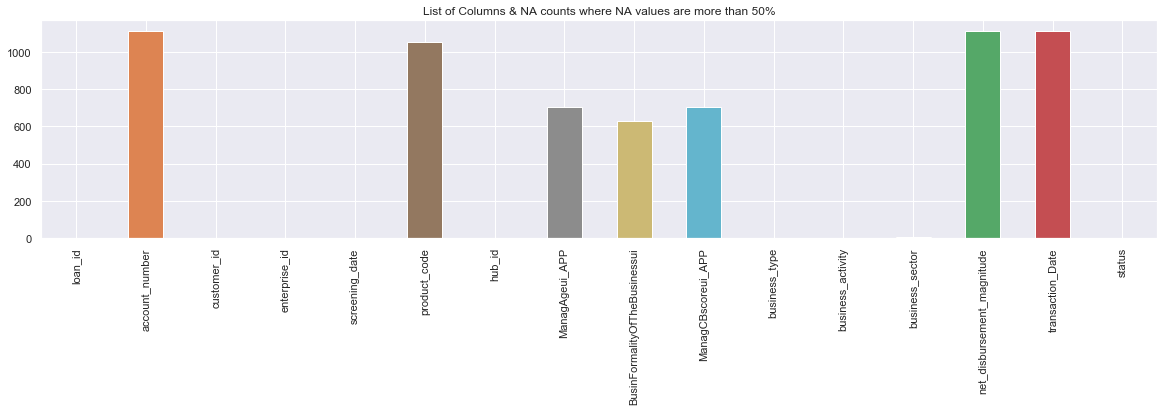

In [230]:
NA_col = p2.isnull().sum()
NA_col = NA_col[NA_col.values <(0.5*len(p2))]
plt.figure(figsize=(20,4))
NA_col.plot(kind='bar')
plt.title('List of Columns & NA counts where NA values are more than 50%')
plt.show()

In [110]:
#HENCE WE WILL DROP THE COLUMN IF WE HAVE AN MISSING VALUES IN EACH COLUMN WHOSE PERCENTAGE IS(>50%)
#WE WONT IMPUTE
#NOW WE WONT DROP AS PER NOW 
#WE WILL IMPUTE ALL NUMERIC VALUES WITH MEAN,MEDIAN AND ALL CATEGORICAL COLUMNS WITH MODE OF THERE SPECIFIC COLUMN.

In [111]:
p2.describe()

,loan_id,customer_id,enterprise_id,hub_id,net_disbursement_magnitude,status
count,2662.000000,2662.000000,2662.000000,2662.000000,1.545000e+03,2662.000000
mean,9963.316679,19435.544328,6635.411721,27.562359,3.227830e+05,0.581142
std,914.100166,5189.368621,2221.717568,15.944133,2.398309e+05,0.493465
min,5692.000000,6569.000000,4.000000,3.000000,4.678900e+04,0.000000
25%,9277.250000,18526.250000,6511.250000,17.250000,1.814710e+05,0.000000
50%,9952.500000,20728.500000,7283.500000,26.000000,2.720620e+05,1.000000
75%,10625.750000,22855.750000,7998.750000,34.000000,3.931880e+05,1.000000
max,25214.000000,62232.000000,21312.000000,97.000000,2.255744e+06,1.000000


In [112]:
#there are some columns which are numeric but representing as object so converting it to float/int

In [231]:
p2['ManagAgeui_APP'] = p2.ManagAgeui_APP.astype(float)
p2['ManagCBscoreui_APP'] = p2.ManagCBscoreui_APP.astype(float)


###  IMPUTATION WITH MEAN(NUMERICAL) AND MODE(CATEGORICAL)

In [232]:
p2['product_code'].fillna((p2['product_code'].mode()), inplace=True)

In [233]:
p2['ManagAgeui_APP'].fillna((p2['ManagAgeui_APP'].mean()), inplace=True)

In [234]:
p2['BusinFormalityOfTheBusinessui'].fillna((p2['BusinFormalityOfTheBusinessui'].mode()), inplace=True)

In [235]:
p2['ManagCBscoreui_APP'].fillna((p2['ManagCBscoreui_APP'].mean()), inplace=True)

In [236]:
p2['business_sector'].fillna((p2['business_sector'].mode()), inplace=True)

In [237]:
p2['net_disbursement_magnitude'].fillna((p2['net_disbursement_magnitude'].mean()), inplace=True)

### FEATURE ENGINEERING:

##### THE COLUMNS WHICH DOES NOT SHOW ANY AFFECT ON TARGET THAT COLUMNS HAS TO BE DROPPED.
##### ACCOUNT number is just used here for reference wheather our status yes,no .hence it wont show prominent affect on target.
##### load_id it is specific loan id which is given to each indivudial it doesnt show prominent affect on target or while predictiing the train on test.
##### customer_id is an indivudial representation given to each coustomer its only for reference it wont affect our target .
##### dates is similar to the above it is used for the reference ,where has it only helpful for us in EDA not in modelling .


#####    the reasons for which we are dropping the column.

In [256]:
p3=p2.drop(['account_number','loan_id','business_sector','product_code','BusinFormalityOfTheBusinessui','customer_id','screening_date','transaction_Date'],axis=1)

## outlier treatment

In [122]:
#Getting percentile distribution for all numeric variables
p3.quantile([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1]).T

,0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99,1.0
enterprise_id,193.22,1130.0,2353.1,6511.250000,7283.500000,7998.750000,8398.9,8520.95,8634.39,21312.0
hub_id,3.00,6.0,11.0,17.250000,26.000000,34.000000,42.0,52.00,92.00,97.0
ManagAgeui_APP,24.61,27.0,29.0,34.000000,38.108218,41.000000,48.0,52.00,58.00,65.0
ManagCBscoreui_APP,0.00,0.0,0.0,626.968351,686.000000,790.000000,810.0,817.00,820.00,840.0
net_disbursement_magnitude,88451.00,126508.7,144141.7,194600.000000,322782.973463,322782.973463,460849.3,637816.25,1102324.75,2255744.0
status,0.00,0.0,0.0,0.000000,1.000000,1.000000,1.0,1.00,1.00,1.0


<IPython.core.display.Javascript object>


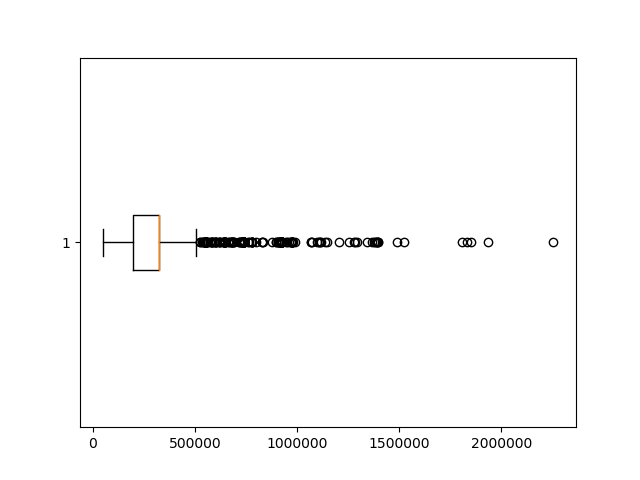

<function matplotlib.pyplot.show(*args, **kw)>

In [126]:
plt.boxplot(p3["net_disbursement_magnitude"],vert=False)
plt.show

<IPython.core.display.Javascript object>


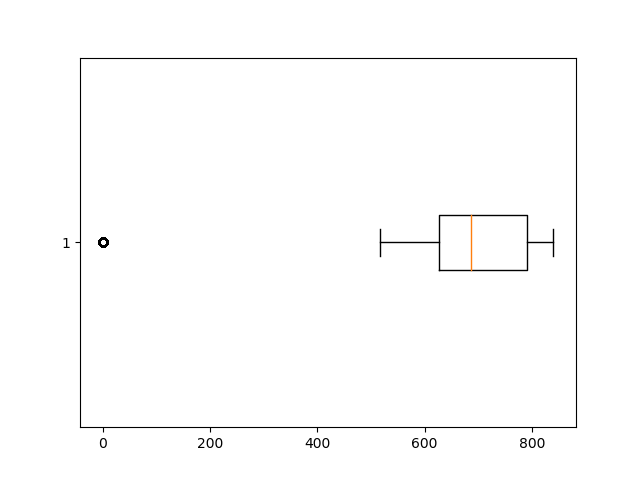

<function matplotlib.pyplot.show(*args, **kw)>

In [127]:
plt.boxplot(p3["ManagCBscoreui_APP"],vert=False)
plt.show

<IPython.core.display.Javascript object>


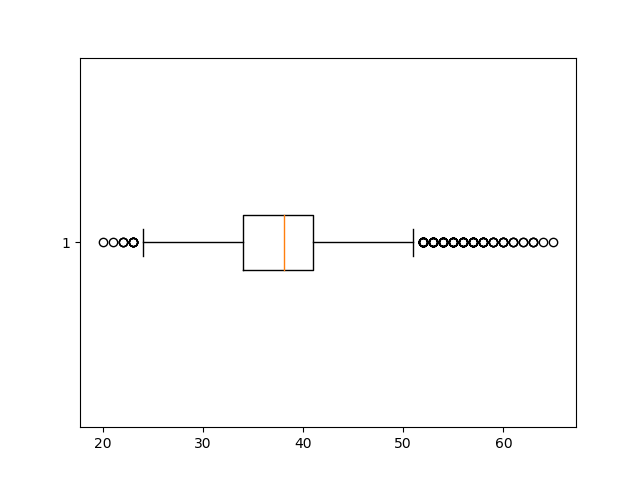

<function matplotlib.pyplot.show(*args, **kw)>

In [128]:
plt.boxplot(p3["ManagAgeui_APP"],vert=False)
plt.show

### we can approch 'capping' which treat the outliers with an required percentile.
###  'net_disbursement_magnitude' ,it has outliers but whereas the the loan disbursement vary from person to    person as per there business ,investment and requirements.so,we cant predominently say it as outliers,for now let us consider it as 'extreme values'.we should not treat without prominent domain knowledge.


In [129]:
# minimum and maximum loan disbursment to various business sectors.
p2.groupby("business_sector")["net_disbursement_magnitude"].describe()[["max","min"]]

,max,min
business_sector,,
Agriculture,4.568120e+05,181156.000000
Apparel,9.199300e+05,90174.000000
Auto Components,2.255744e+06,46789.000000
Automobiles,7.370530e+05,87649.000000
Bedding,3.216100e+05,321610.000000
Book Stores,3.227830e+05,87649.000000
Chemicals,7.399190e+05,181246.000000
Construction,4.612230e+05,88312.000000
Construction Material,9.076410e+05,88312.000000


In [133]:
#where as loan disbursed to 1547,and not disbursed to 1115
temp = pd.DataFrame(p2.status.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['status','count']
temp

,status,count
0,1.0,1547
1,0.0,1115


<IPython.core.display.Javascript object>


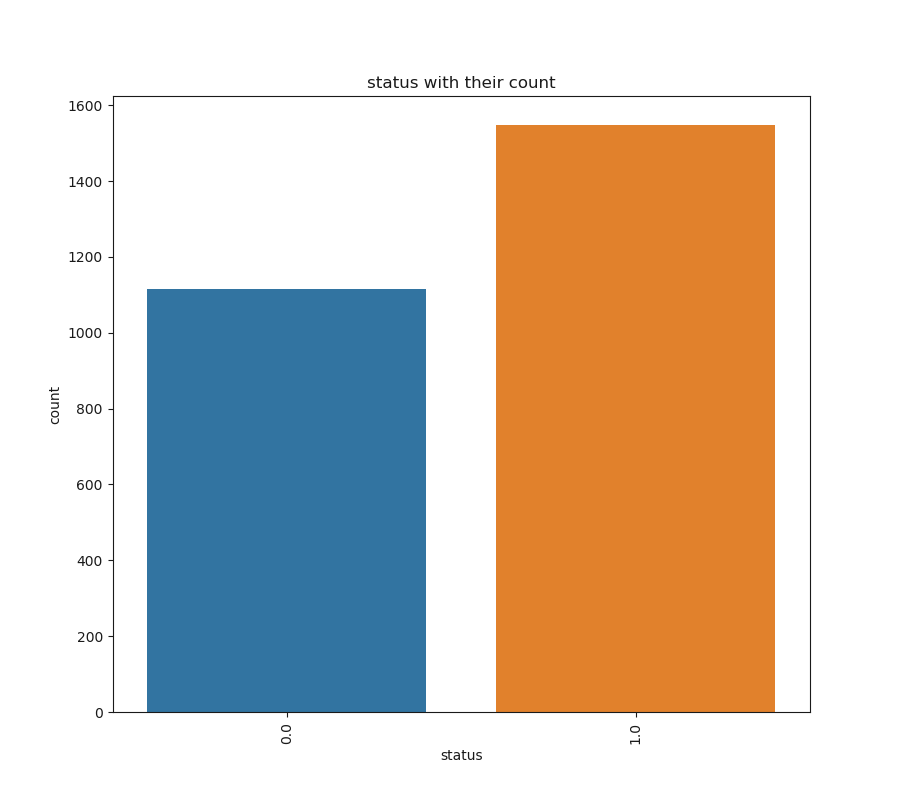

In [134]:
# Plot the Sites with their count
plt.figure(figsize = (9, 8))
plt.title('status with their count')
sns.set_color_codes("pastel")
sns.barplot(x='status', y="count", data=temp,
            label="Count")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

<IPython.core.display.Javascript object>


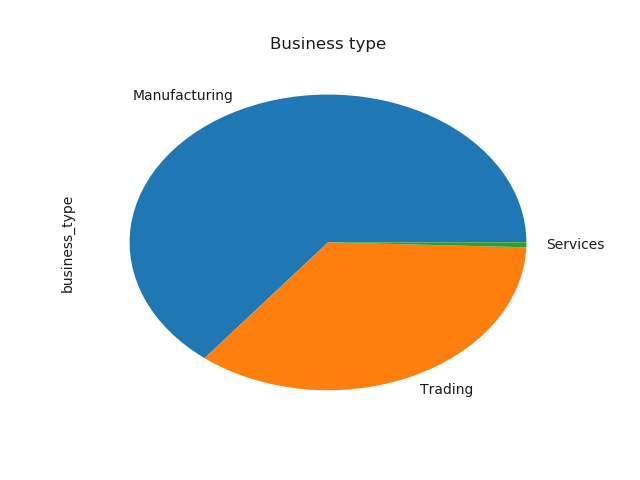

Text(0.5,1,'Business type')

In [136]:
p2['business_type'].value_counts().plot(kind='pie')

plt.title('Business type')

In [137]:
p2['business_type'].value_counts()

Manufacturing    1712
Trading           936
Services           14
Name: business_type, dtype: int64

In [ ]:
#we can see that majority of the loan applied by 'manufacturing sector'

In [148]:
p2['business_activity'].value_counts()

Job Work & Sales                 823
Sales                            557
Retail                           554
Whole Sale                       382
Job Work                         332
Retail (Business to Customer)      9
Retail (Business to Business)      5
Name: business_activity, dtype: int64

<IPython.core.display.Javascript object>


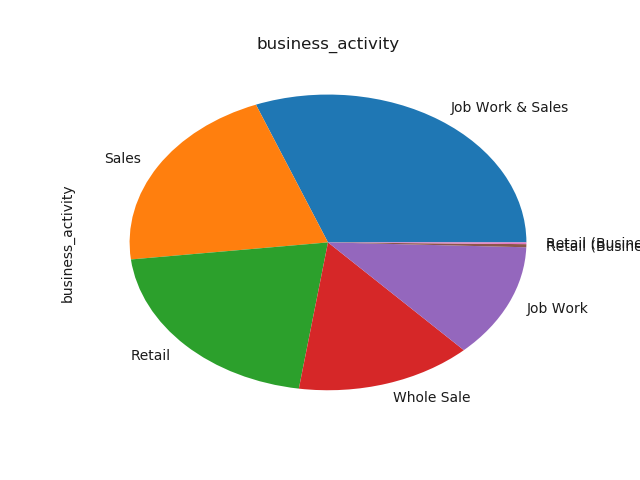

Text(0.5,1,'business_activity')

In [149]:
p2['business_activity'].value_counts().plot(kind='pie')

plt.title('business_activity')

In [ ]:
#highest business activity in 'Job Work & Sales'

In [152]:
temp = pd.DataFrame(p2.business_sector.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['business_sector','count']
temp

,business_sector,count
0,Auto Components,394
1,Machine Components,345
2,Food & Beverage,272
3,Fabrication,220
4,Fashion,219
5,Plastics,131
6,Textiles,124
7,Food Products,119
8,Paper,78
9,Wood,72


In [ ]:
# we have total number of '36'= business-sector'

<IPython.core.display.Javascript object>


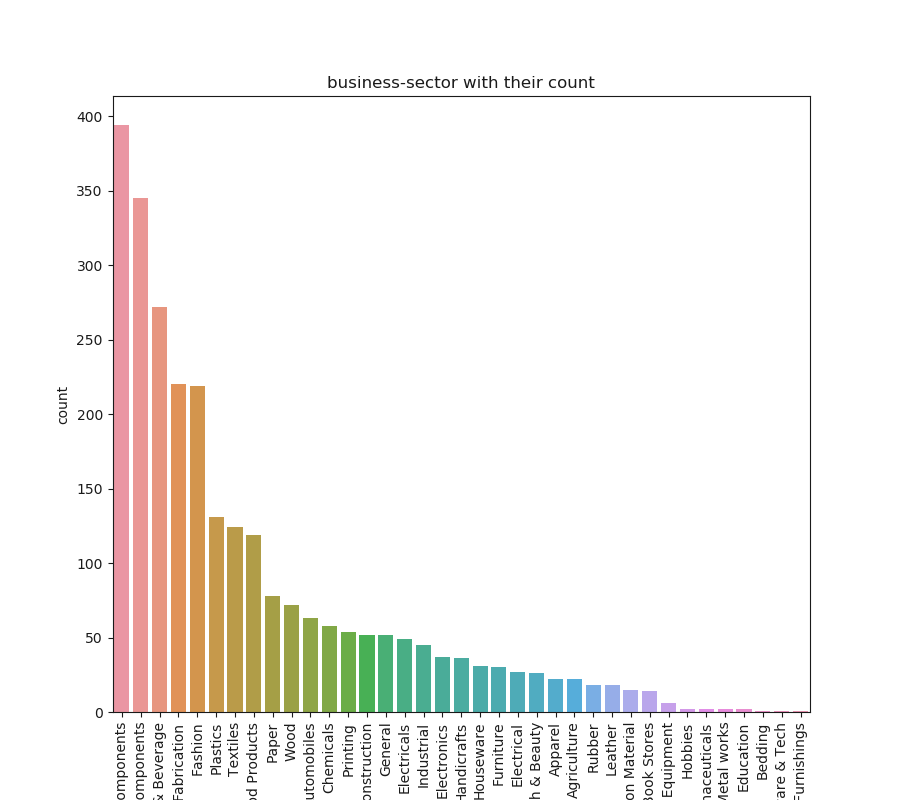

In [154]:
# Plot the Sites with their count
plt.figure(figsize = (9, 8))
plt.title('business-sector with their count')
sns.set_color_codes("pastel")
sns.barplot(x='business_sector', y="count", data=temp,
            label="Count")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [156]:
temp = pd.DataFrame(p2.BusinFormalityOfTheBusinessui.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['BusinFormalityOfTheBusinessui','count']
temp

,BusinFormalityOfTheBusinessui,count
0,Cash & Non Banked,1344
1,Invoice & Banked,368
2,Invoice & Non Banked,236
3,Cash & Banked,83


In [157]:
#business formality we have majorly==>1344

In [158]:
def univariate(df,col,vartype,hue =None):
    
    '''
    Univariate function will plot the graphs based on the parameters.
    df      : dataframe name
    col     : Column name
    vartype : variable type : continuos or categorical
                Continuos(0)   : Distribution, Violin & Boxplot will be plotted.
                Categorical(1) : Countplot will be plotted.
    hue     : It's only applicable for categorical analysis.
    
    '''
    sns.set(style="darkgrid")
    
    if vartype == 0:
        fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
        ax[0].set_title("Distribution Plot")
        sns.distplot(df[col],ax=ax[0])
        ax[1].set_title("Violin Plot")
        sns.violinplot(data =df, x=col,ax=ax[1], inner="quartile")
        ax[2].set_title("Box Plot")
        sns.boxplot(data =df, x=col,ax=ax[2],orient='v')
    
    if vartype == 1:
        temp = pd.Series(data = hue)
        fig, ax = plt.subplots()
        width = len(df[col].unique()) + 6 + 4*len(temp.unique())
        fig.set_size_inches(width , 7)
        ax = sns.countplot(data = df, x= col, order=df[col].value_counts().index,hue = hue) 
        if len(temp.unique()) > 0:
            for p in ax.patches:
                ax.annotate('{:1.1f}%'.format((p.get_height()*100)/float(len(loan))), (p.get_x()+0.05, p.get_height()+20))  
        else:
            for p in ax.patches:
                ax.annotate(p.get_height(), (p.get_x()+0.32, p.get_height()+20)) 
        del temp
    else:
        exit
        
    plt.show()

<IPython.core.display.Javascript object>


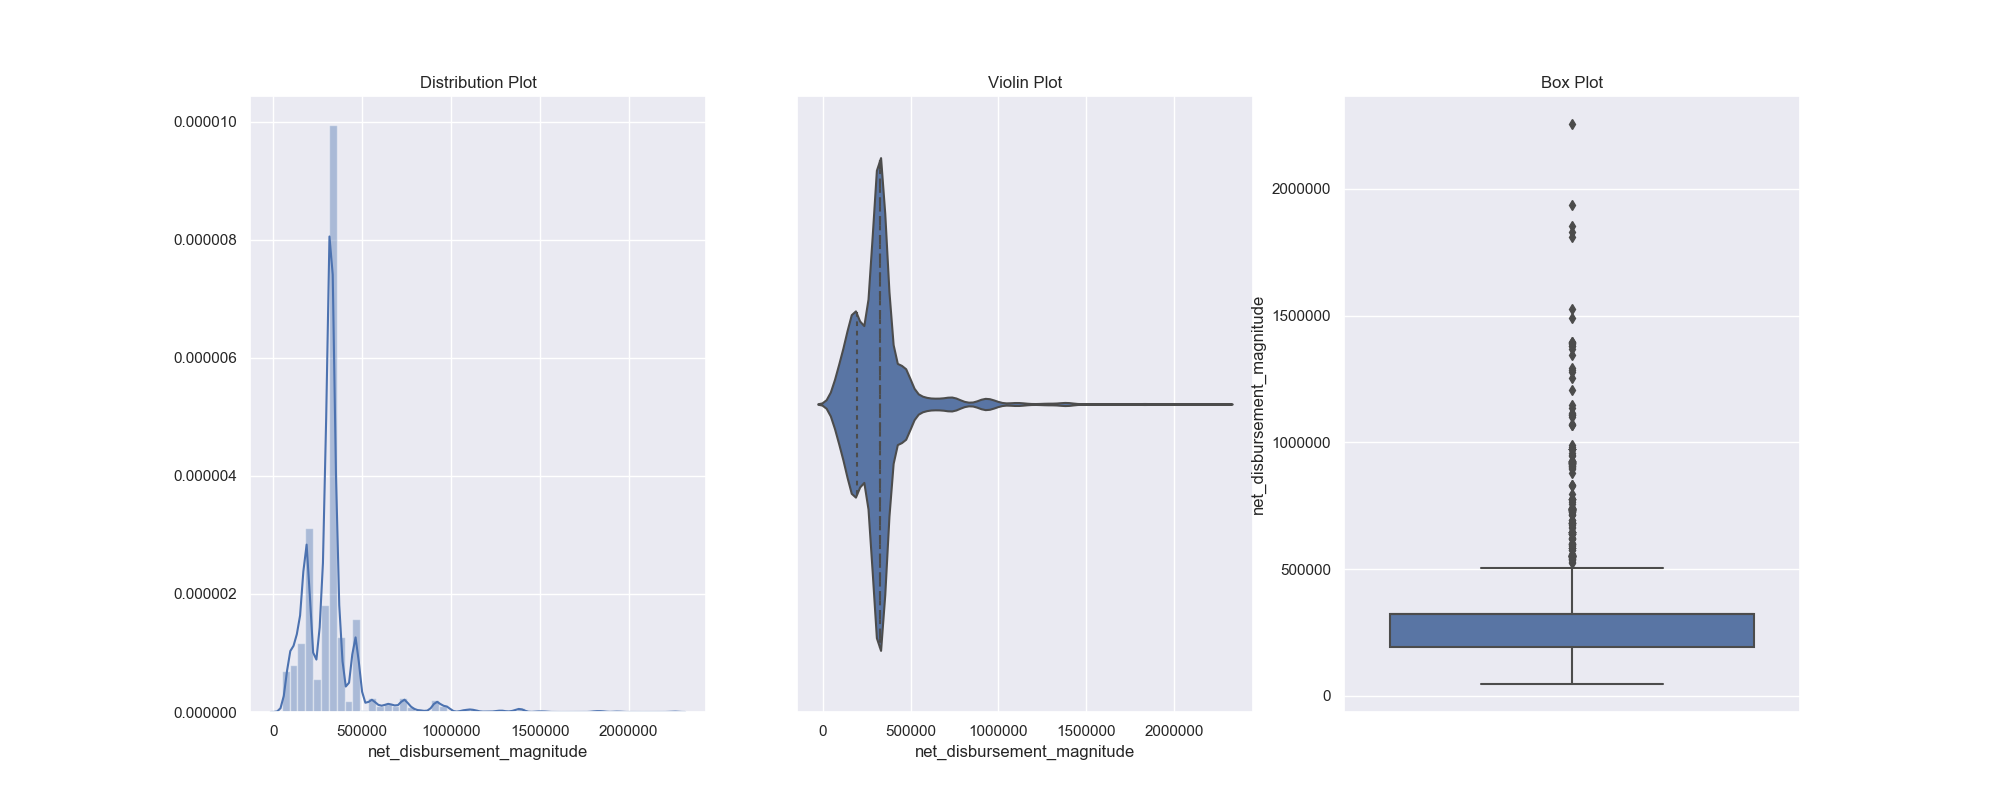

E:\installed anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [159]:
univariate(df=p2,col='net_disbursement_magnitude',vartype=0)

In [ ]:
#for the above univarite plot of loan disbursment we can observe that loan which are disbursed majorly for ,
## the amount between '400000-500000'.,,maximum loan disbursed upto 2crores(+).

In [160]:
# crosstab 
pd.crosstab(p2.status, p2.business_type)

business_type,Manufacturing,Services,Trading
status,,,
0.0,683,11,421
1.0,1029,3,515


<IPython.core.display.Javascript object>


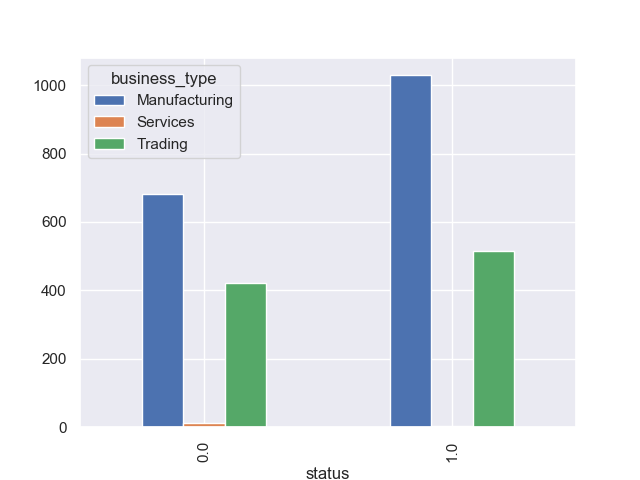

In [161]:
pd.crosstab(p2.status, p2.business_type).plot(kind='bar');

In [ ]:
# we can observe that majority of loans applied by 'Manufacturing Sector' in which 
1->manufacturing sector applied for loan in which '1029' are sanctioned and '683' are not sanctioned.
2->Service sector applied for loan in which '3' are sanctioned and '11' are not sanctioned.
3->Trading sector sector applied for loan in which '515' are sanctioned and '421' are not sanctioned.

In [169]:
pd.crosstab(p2.status, p2.business_activity)

business_activity,Job Work,Job Work & Sales,Retail,Retail (Business to Business),Retail (Business to Customer),Sales,Whole Sale
status,,,,,,,
0.0,146,358,255,3,8,179,166
1.0,186,465,299,2,1,378,216


In [ ]:
pd.crosstab(p2.status, p2.business_activity)

<IPython.core.display.Javascript object>


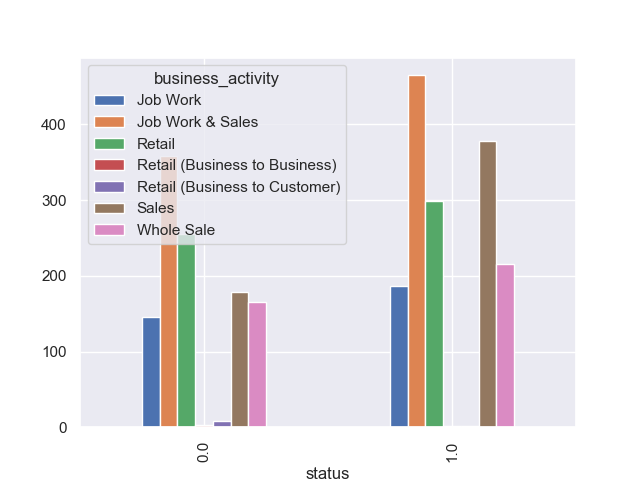

In [183]:
pd.crosstab(p2.status, p2.business_activity).plot(kind='bar');

In [ ]:
#we can see that more describly for which all activities the loans are sanctioned.
loan sanctioned rate  for business activity-'Job Work'         = 56%
loan sanctioned rate  for business activity-'Job Work & Sales' = 56%
loan sanctioned rate  for business activity-'Retail'         = 54%
loan sanctioned rate  for business activity-'Retail(Business to Business)'  = 40%
loan sanctioned rate  for business activity-'Retail (Business to Customer)'  = 1.1%
loan sanctioned rate  for business activity-'Sales'            =  67%
loan sanctioned rate  for business activity-'Whole Sale'         = 56%

In [186]:
p3.pivot_table(index='business_type',columns = 'business_activity',values='net_disbursement_magnitude')

business_activity,Job Work,Job Work & Sales,Retail,Retail (Business to Business),Retail (Business to Customer),Sales,Whole Sale
business_type,,,,,,,
Manufacturing,307018.801583,342369.447719,NaN,NaN,NaN,364800.853184,NaN
Services,NaN,NaN,NaN,340210.584078,430456.8653,NaN,NaN
Trading,NaN,NaN,273501.538327,NaN,NaN,NaN,301724.8314


<IPython.core.display.Javascript object>


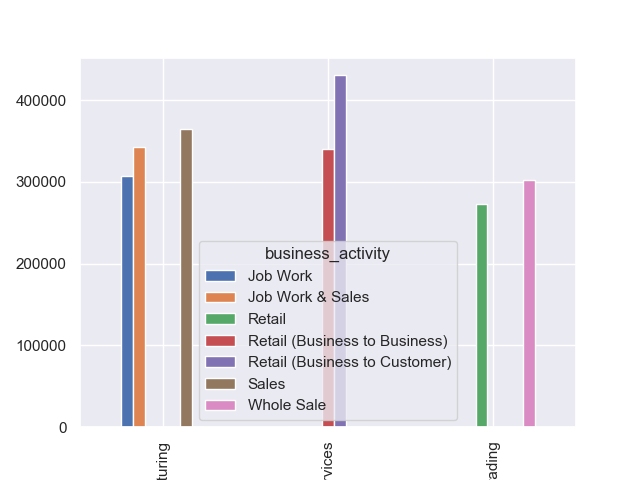

In [187]:
p3.pivot_table(index='business_type',columns = 'business_activity',values='net_disbursement_magnitude').plot(kind='bar');

In [ ]:
#from above graph we can understand that high amount of loan disbursed of top-3:
->business activity='Retail (Business to Customer)' = Rs:430456.8653      
->business activity='Sales' = Rs:364800.853184
->business activity='Job Work & Sales' = Rs:342369.447719

<IPython.core.display.Javascript object>


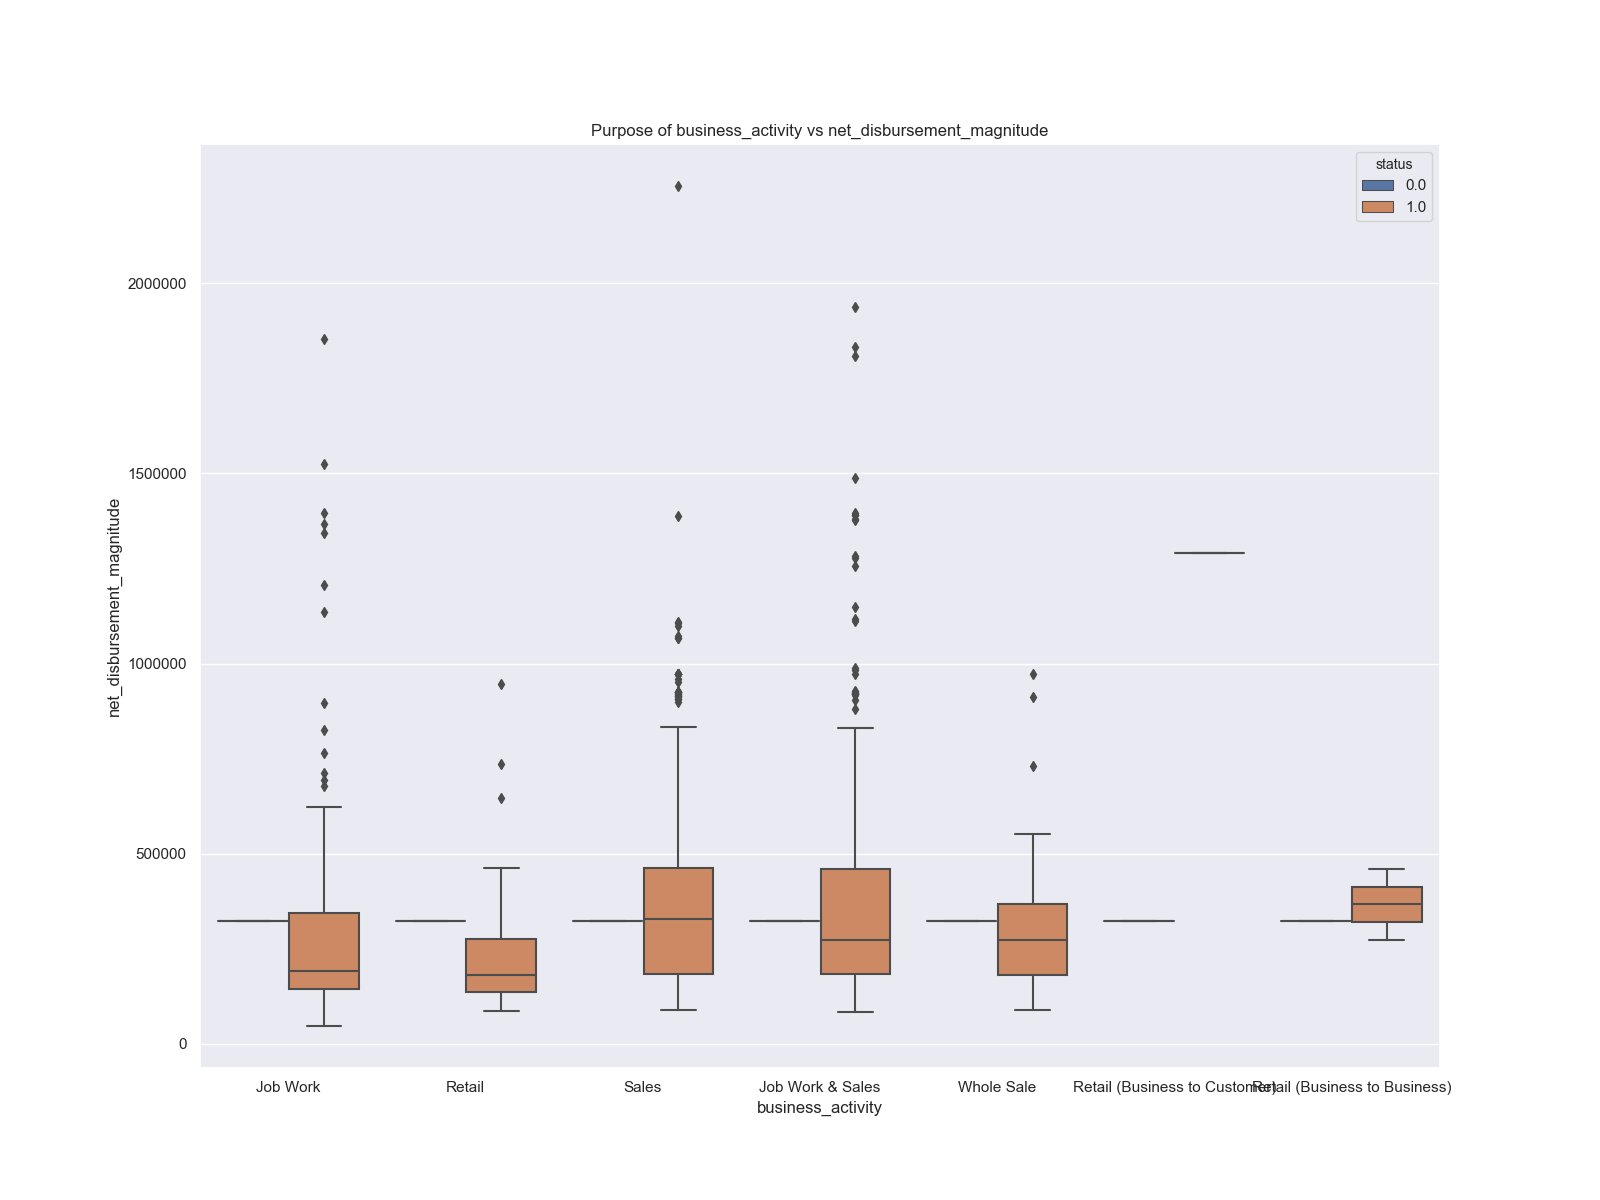

In [198]:
plt.figure(figsize=(16,12))
sns.boxplot(data =p2, x='business_activity', y='net_disbursement_magnitude', hue ='status')
plt.title('Purpose of business_activity vs net_disbursement_magnitude')
plt.show()

<IPython.core.display.Javascript object>


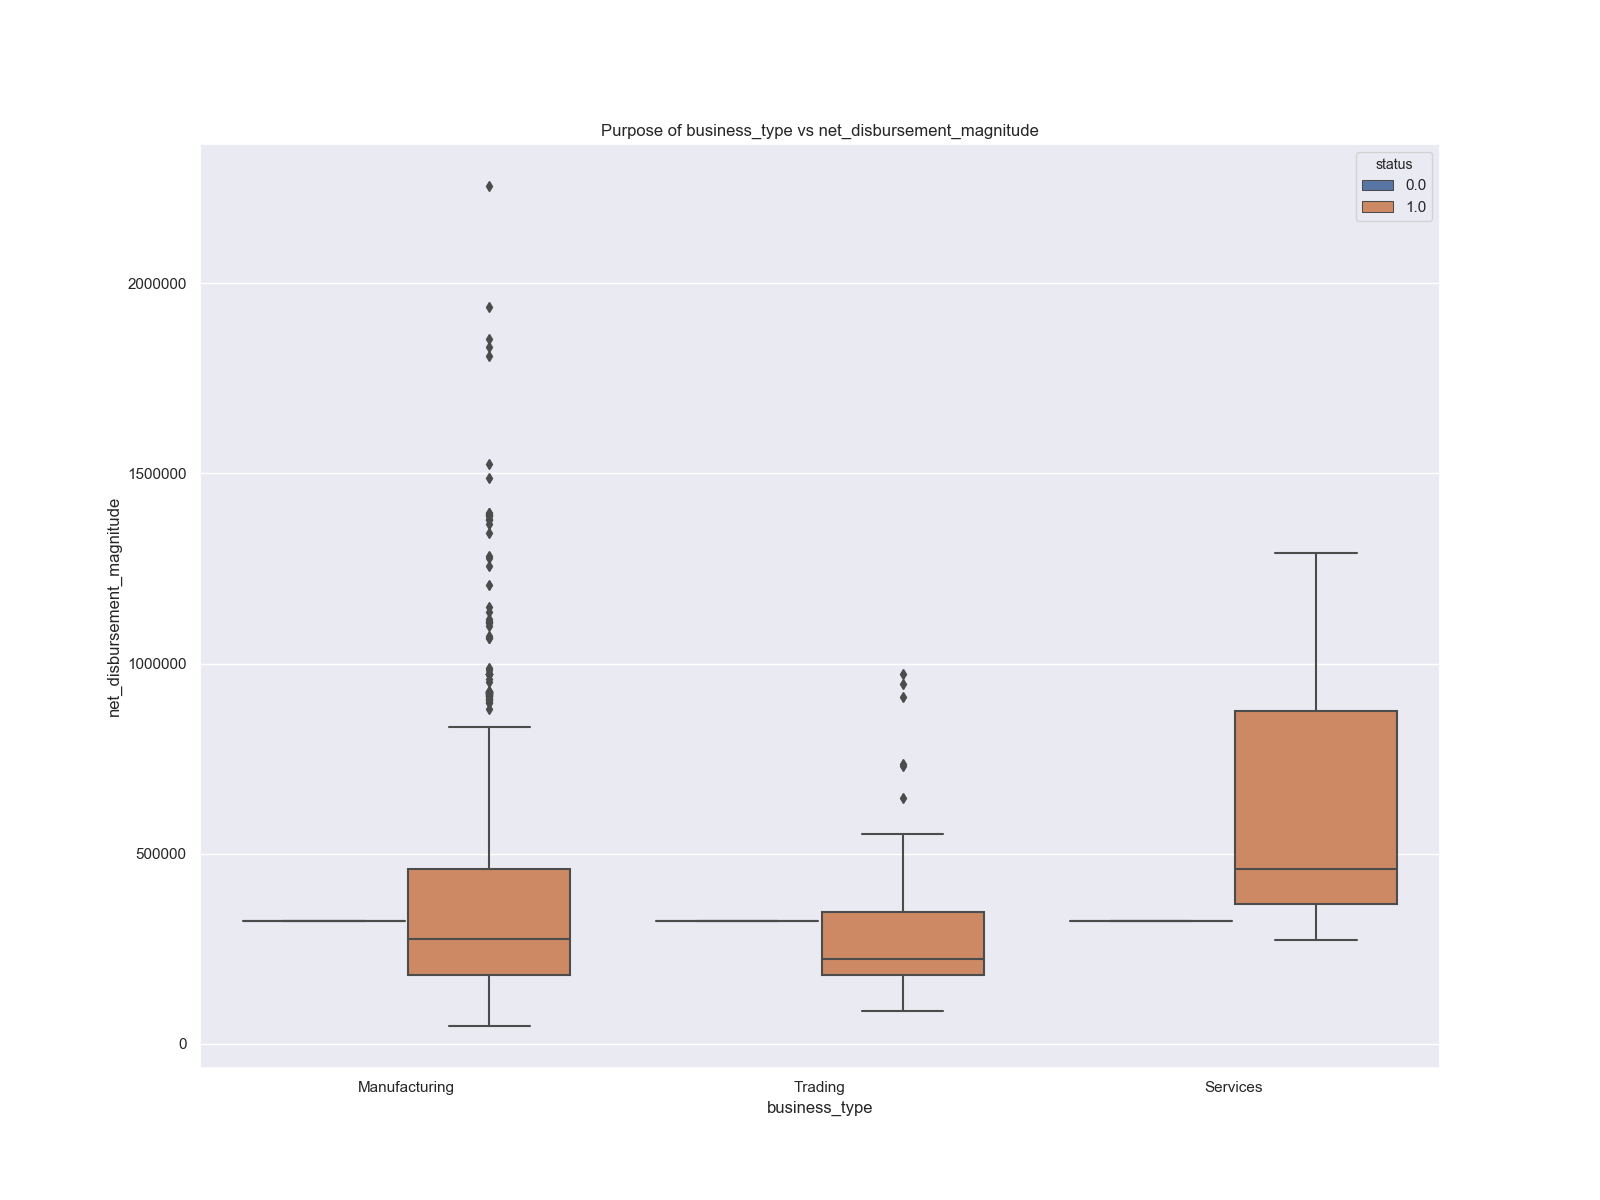

In [199]:
plt.figure(figsize=(16,12))
sns.boxplot(data =p2, x='business_type', y='net_disbursement_magnitude', hue ='status')
plt.title('Purpose of business_type vs net_disbursement_magnitude')
plt.show()

In [200]:
loan_correlation = p2.corr()
loan_correlation

,loan_id,customer_id,enterprise_id,hub_id,ManagAgeui_APP,ManagCBscoreui_APP,net_disbursement_magnitude,status
loan_id,1.000000,0.468003,0.387332,-0.000458,-0.040488,0.017443,-1.167815e-01,-1.268118e-01
customer_id,0.468003,1.000000,0.989936,0.124277,-0.046264,-0.128745,-2.031820e-01,-2.293889e-01
enterprise_id,0.387332,0.989936,1.000000,0.130361,-0.045190,-0.133752,-2.009440e-01,-2.231330e-01
hub_id,-0.000458,0.124277,0.130361,1.000000,-0.004002,-0.019664,-3.904855e-02,9.629310e-02
ManagAgeui_APP,-0.040488,-0.046264,-0.045190,-0.004002,1.000000,0.061469,5.131405e-02,-1.628738e-02
ManagCBscoreui_APP,0.017443,-0.128745,-0.133752,-0.019664,0.061469,1.000000,7.482375e-02,5.267848e-02
net_disbursement_magnitude,-0.116782,-0.203182,-0.200944,-0.039049,0.051314,0.074824,1.000000e+00,6.631510e-16
status,-0.126812,-0.229389,-0.223133,0.096293,-0.016287,0.052678,6.631510e-16,1.000000e+00


<IPython.core.display.Javascript object>


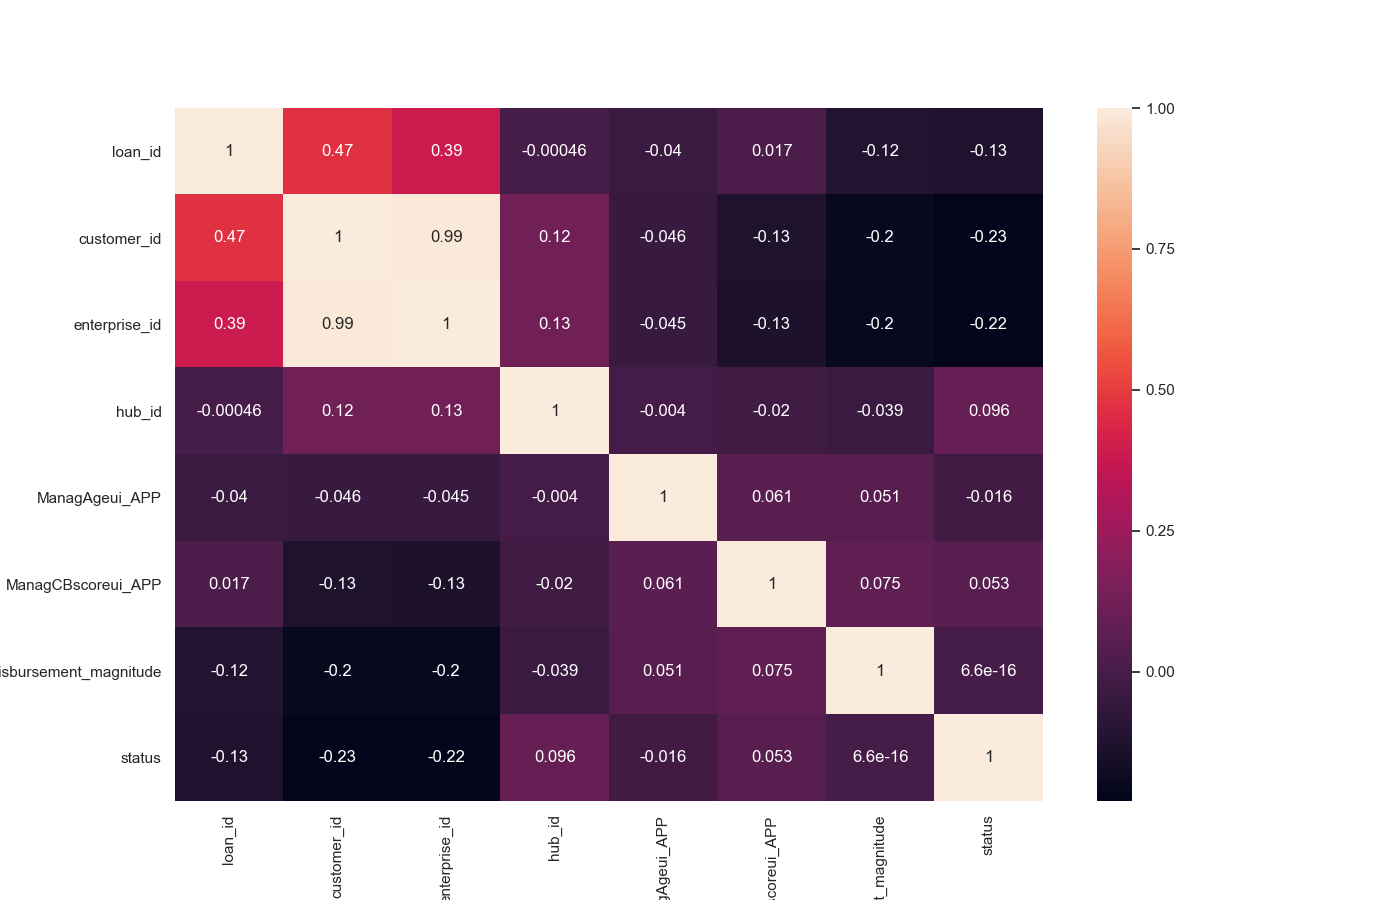

In [201]:
f, ax = plt.subplots(figsize=(14, 9))
sns.heatmap(loan_correlation, 
            xticklabels=loan_correlation.columns.values,
            yticklabels=loan_correlation.columns.values,annot= True)
plt.show()

In [ ]:
It is clear from the Heatmap that how 'customer_id','enterprise_id' 
are closely interrelated.So we can take any one column out of them for our analysis.

In [ ]:
here our major variables to consider 'loan disbursment','business activity','business sector','business type','status'.

# Chi-square test of independence

In [ ]:
Null hypothesis:H0: The variables are dependent
Alternative hypothesis: HA: The variables are independent
Significance level:0.05

In [295]:
for i in p2.columns:
    if p2[i].dtype == 'object':
        a,p,b,_=chi2_contingency(pd.crosstab(p2.status,p2[i]))
        print("status",i,p)

status account_number 1.0
status product_code 0.22982032486705092
status BusinFormalityOfTheBusinessui 0.14534351853429664
status business_type 0.0008223741993798168
status business_activity 2.3441352097290394e-06
status business_sector 1.9675369610486073e-06


# MODEL BUILDING

In [203]:
p_dummies=pd.get_dummies(p3)
p_dummies.shape

(2662, 70)

## For converting categorical variables to numerical variables, if we use dummies the column count is increasing to 70.
## It is not desired because because we have only 2662 rows. so lets do label encoding.

In [250]:
le=preprocessing.LabelEncoder()


In [258]:
p5=p3.apply(le.fit_transform)

In [259]:
x=p5.drop('status',axis=1)
y=p5['status']

In [260]:
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.3,random_state=7,stratify=y)

# DECISION TREE CLASSIFIER

In [285]:
dtree=tree.DecisionTreeClassifier(max_depth=5,random_state=5,criterion='entropy')
dtree.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=5,
            splitter='best')

In [286]:
ypred_dtree=dtree.predict(x_test)
print('Accuracy:',accuracy_score(y_test,ypred_dtree))
print(classification_report(y_test,ypred_dtree))

Accuracy: 0.9987484355444305
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       335
          1       1.00      1.00      1.00       464

avg / total       1.00      1.00      1.00       799



In [287]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = dtree, X = x_train, y = y_train, cv = 4)
accuracies.mean(),accuracies.std()

(0.9983894042180073, 0.0009298798168879523)

In [288]:
accuracies

array([0.99785408, 1.        , 0.99785408, 0.99784946])

Area under curve 0.9989224137931034


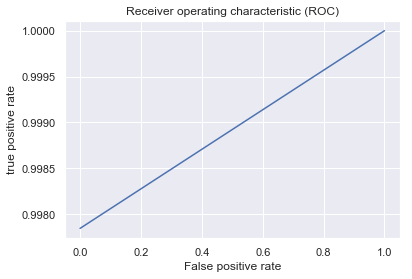

In [289]:
fpr, tpr, thresholds = roc_curve(y_test, ypred_dtree )
roc_auc= auc(fpr,tpr)

print('Area under curve',roc_auc )
plt.figure()
plt.plot(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver operating characteristic (ROC)')
plt.show()

# As we can see our model is showing almost same cross-validation score for all the four different splits.So our model is not overfitted.

                            importance                     columns
net_disbursement_magnitude    0.993952  net_disbursement_magnitude
enterprise_id                 0.006048               enterprise_id
hub_id                        0.000000                      hub_id
ManagAgeui_APP                0.000000              ManagAgeui_APP
ManagCBscoreui_APP            0.000000          ManagCBscoreui_APP
business_type                 0.000000               business_type
business_activity             0.000000           business_activity


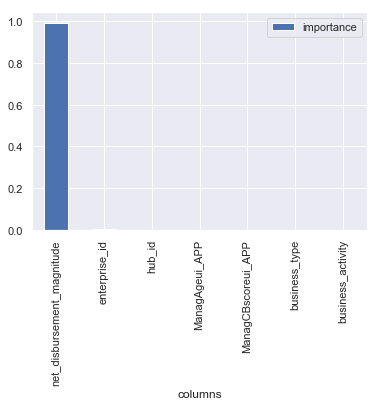

In [290]:
feature_importances = pd.DataFrame(dtree.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances
feature_importances['columns']=feature_importances.index
print(feature_importances)

feature_importances.plot(kind='bar',x='columns',y='importance')

The Model has an improved its performance after removing redundant features.

Now we want to check whether our model is overfitted or not
For that we dont have any test data available. We have to use only the available data
So, Let us do KFOLD cross validation.

# Random Forest Classifier

In [291]:
rf=RandomForestClassifier(n_estimators=10,random_state=10)
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [292]:
ypred_rf=rf.predict(x_test)
print('Accuracy:',accuracy_score(y_test,ypred_rf))
print(classification_report(y_test,ypred_rf))

Accuracy: 0.9949937421777222
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       335
          1       1.00      0.99      1.00       464

avg / total       1.00      0.99      0.99       799



In [293]:
# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = rf, X = x_train, y = y_train, cv = 5)
accuracies.mean(),accuracies.std()

(0.9957061316267405, 0.003641108511022014)

In [280]:
accuracies

array([1.        , 0.99731903, 0.99463807, 1.        , 0.99462366])

In [272]:
fpr,tpr,_=roc_curve(y_test,ypred_rf)
roc_auc2=auc(fpr,tpr)

Area under curve 0.9967672413793103


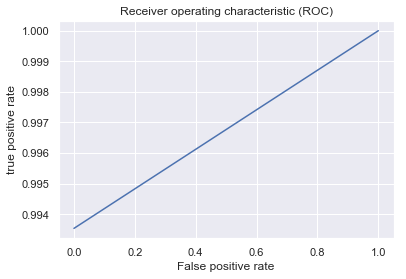

In [275]:
print('Area under curve',roc_auc )
plt.figure()
plt.plot(fpr,tpr)
plt.xlabel('False positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver operating characteristic (ROC)')
plt.show()

# As we can see our model is showing almost same cross-validation score for all the five different splits.So our model is not overfitted.

                            importance                     columns
net_disbursement_magnitude    0.649355  net_disbursement_magnitude
ManagCBscoreui_APP            0.146537          ManagCBscoreui_APP
ManagAgeui_APP                0.099700              ManagAgeui_APP
enterprise_id                 0.058857               enterprise_id
hub_id                        0.029872                      hub_id
business_activity             0.010807           business_activity
business_type                 0.004872               business_type


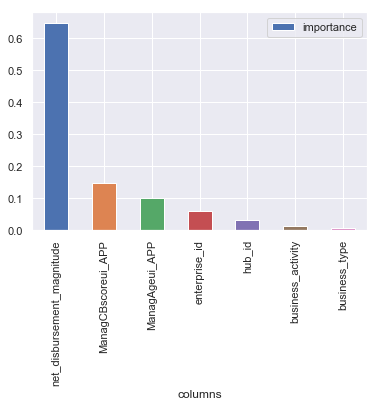

In [282]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances
feature_importances['columns']=feature_importances.index
print(feature_importances)

feature_importances.plot(kind='bar',x='columns',y='importance')

The Model has an improved its performance after removing redundant features.

Now we want to check whether our model is overfitted or not
For that we dont have any test data available. We have to use only the available data
So, Let us do KFOLD cross validation.

## we have better accuracy in 'Random Forest TREE MODEL'.-and it giving importance of all the variables where are decision tree gives more importance to only loan disbursment amount
    WE GO WITH random forest TREE MODEL